##  ewf-ext-02-03-01 - Landsat-7 and -8 NDVI time series

Landsat-7 and -8 NDVI time series

### <a name="service">Service Definition

In [604]:
service = dict([('title', 'Landsat-7 and -8 NDVI time series'),
                ('abstract', 'Landsat-7 and -8 NDVI time series'),
                ('id', 'ewf-ext-02-03-01')])

### <a name="parameter">Parameter Definition 

In [605]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                         ('value', 'POLYGON ((-8.864205 38.88616500000001, -8.864205 38.986165, -8.964205000000002 38.986165, -8.964205000000002 38.88616500000001, -8.864205 38.88616500000001))'),
                         ('title', 'WKT Polygon for the Region of Interest'),
                         ('abstract', 'Set the value of WKT Polygon')])

In [606]:
nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', 'Leziria'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifier**

This is the Sentinel-2 product identifier

In [607]:
#input_identifier = 'LE07_L1TP_204033_20171130_20171226_01_T1'

**Input reference**

This is the Landsat-7 (espa-sr) catalogue reference

In [608]:
# Landsat 7

input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20171130_20171226_01_T1'
#input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20171114_20171210_01_T1'
#input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20170927_20171023_01_T1'
#input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20170911_20171007_01_T1'
#input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20170810_20170905_01_T1'
#input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20170725_20170820_01_T1'


# Landsat 8

#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190723_20190801_01_T1'
input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190707_20190719_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190621_20190704_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190605_20190618_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190520_20190604_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190504_20190520_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190418_20190423_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190402_20190421_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190317_20190325_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190301_20190309_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190213_20190222_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190128_20190206_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20190112_20190131_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1GT_204033_20181227_20190129_01_T2'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1GT_204033_20181211_20181226_01_T2'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1GT_204033_20181125_20181210_01_T2'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20181109_20181127_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20181024_20181031_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20181008_20181029_01_T1'
#input_reference = 'https://catalog.terradue.com/landsat8/search?format=atom&uid=LC08_L1TP_204033_20180922_20180928_01_T1'


**Data path**

This path defines where the data is staged-in. 

In [609]:
#data_path = '/workspace/data'

###  Aux folders

In [610]:
output_folder = ''

In [611]:
temp_folder = 'temp'

### <a name="workflow">Workflow

#### Import the packages required for processing the Landsat vegetation indices

In [612]:
import os
import sys

from urlparse import urlparse

from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.wkt import loads
from shapely.geometry import box
import cioppy
import lxml.etree as etree
#import gdal
#import osr

#import numpy as np
from osgeo import gdal, ogr, osr

import numpy as np
from geopandas import GeoDataFrame
import pandas as pd
import geopandas as gp

import glob


ciop = cioppy.Cioppy()

###  Auxiliary vars

In [613]:
check_results = True

###  Auxiliary methods

In [614]:
 # remove contents of a given folder
# used to clean a temporary folder
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

###   Auxiliary folders

In [615]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

### Define the AOI

In [616]:

#point_of_interest = Point(-9.189, 38.733)
#point_of_interest = Point(-8.914205, 38.936165)


In [617]:
#buffer_size = 0.05

In [618]:
#aoi_wkt = box(*point_of_interest.buffer(buffer_size).bounds)

aoi_wkt = loads(regionOfInterest['value'])

In [619]:
aoi_wkt.wkt

'POLYGON ((-8.864205 38.88616500000001, -8.864205 38.986165, -8.964205000000002 38.986165, -8.964205000000002 38.88616500000001, -8.864205 38.88616500000001))'

In [620]:
bbox = list(aoi_wkt.bounds)
bbox

[-8.964205000000002, 38.88616500000001, -8.864205, 38.986165]

In [621]:
def eop_metadata(metadata):

    opt = 'http://www.opengis.net/opt/2.1'
    om  = 'http://www.opengis.net/om/2.0'
    gml = 'http://www.opengis.net/gml/3.2'
    eop = 'http://www.opengis.net/eop/2.1'
    sar = 'http://www.opengis.net/sar/2.1'
    
    root = etree.Element('{%s}EarthObservation' % opt)

    phenomenon_time = etree.SubElement(root, '{%s}phenomenonTime' % om)

    time_period = etree.SubElement(phenomenon_time, '{%s}TimePeriod' % gml)

    begin_position = etree.SubElement(time_period, '{%s}beginPosition'  % gml)

    end_position = etree.SubElement(time_period, '{%s}endPosition'  % gml)

    procedure = etree.SubElement(root, '{%s}procedure' % om)

    earth_observation_equipment = etree.SubElement(procedure, '{%s}EarthObservationEquipment' % eop)

    acquisition_parameters = etree.SubElement(earth_observation_equipment, '{%s}acquisitionParameters' % eop)

    acquisition = etree.SubElement(acquisition_parameters, '{%s}Acquisition' % sar)

    orbit_number = etree.SubElement(acquisition, '{%s}orbitNumber' % eop)

    wrs_longitude_grid = etree.SubElement(acquisition, '{%s}wrsLongitudeGrid' % eop)

    wrs_latitude_grid = etree.SubElement(acquisition, '{%s}wrsLatitudeGrid' % eop)
    
    
    feature_of_interest = etree.SubElement(root, '{%s}featureOfInterest' % om)
    footprint = etree.SubElement(feature_of_interest, '{%s}Footprint' % eop)
    multi_extentOf = etree.SubElement(footprint, '{%s}multiExtentOf' % eop)
    multi_surface = etree.SubElement(multi_extentOf, '{%s}MultiSurface' % gml)
    surface_members = etree.SubElement(multi_surface, '{%s}surfaceMembers' % gml)
    polygon = etree.SubElement(surface_members, '{%s}Polygon' % gml)    
    exterior = etree.SubElement(polygon, '{%s}exterior' % gml)  
    linear_ring = etree.SubElement(exterior, '{%s}LinearRing' % gml) 
    poslist = etree.SubElement(linear_ring, '{%s}posList' % gml) 


    result = etree.SubElement(root, '{%s}result' % om)
    earth_observation_result = etree.SubElement(result, '{%s}EarthObservationResult' % opt)
    cloud_cover_percentage = etree.SubElement(earth_observation_result, '{%s}cloudCoverPercentage' % opt)
    
    metadata_property = etree.SubElement(root, '{%s}metaDataProperty' % eop)
    earth_observation_metadata = etree.SubElement(metadata_property, '{%s}EarthObservationMetaData' % eop)
    identifier = etree.SubElement(earth_observation_metadata, '{%s}identifier' % eop)
    
    begin_position.text = metadata['startdate']
    end_position.text = metadata['enddate']
    orbit_number.text = metadata['orbitNumber']
    wrs_longitude_grid.text = metadata['wrsLongitudeGrid']
    wrs_latitude_grid.text = metadata['wrsLatitudeGrid']
    
    coords = np.asarray([t[::-1] for t in list(loads(metadata['wkt']).exterior.coords)]).tolist()
 
    pos_list = ''
    for elem in coords:
        pos_list += ' '.join(str(e) for e in elem) + ' '   

    poslist.attrib['count'] = str(len(coords))
    poslist.text = pos_list
    
    
    identifier.text = metadata['identifier']

    return etree.tostring(root, pretty_print=True)

#### Get the metadata of the Landsat 7 product

In [622]:
#ciop = cioppy.Cioppy()

temp_results = []

search_params = dict()

search_params['do'] = 'terradue'

ls7_catalogue_metadata = ciop.search(end_point=input_reference,
                                     params=[],
                                     output_fields='enclosure,identifier,startdate,enddate,wkt,orbitNumber,swathIdentifier,wrsLongitudeGrid,wrsLatitudeGrid',
                                     model='EOP')[0]


In [623]:
ls7_catalogue_metadata

{'enclosure': 'https://store.terradue.com/download/landsat8/files/v1/LC08_L1TP_204033_20190707_20190719_01_T1',
 'enddate': '2019-07-07T11:14:42.5370000Z',
 'identifier': 'LC08_L1TP_204033_20190707_20190719_01_T1',
 'orbitNumber': '',
 'startdate': '2019-07-07T11:14:10.7670000Z',
 'swathIdentifier': '',
 'wkt': 'POLYGON((-10.19581 38.23919,-8.08182 37.83637,-7.52607 39.55302,-9.69152 39.95757,-10.19581 38.23919))',
 'wrsLatitudeGrid': '33',
 'wrsLongitudeGrid': '204'}

### Get the Landsat product bands (geotiff)

* Get the download url
* Extract the needed bands cropping them with respect to the defined AOI

check if it is landsat 7 or 8

In [624]:
# 'LE07' - Landsat 7
# 'LC08' - Landsat 8
lscode = ls7_catalogue_metadata['identifier'][0:4]
if lscode == 'LC08':
    print('Landsat 8')
else:
    print('Landsat 7')

Landsat 8


In [625]:
ls7_tif_url = ls7_catalogue_metadata['enclosure']

print ls7_tif_url

https://store.terradue.com/download/landsat8/files/v1/LC08_L1TP_204033_20190707_20190719_01_T1


In [626]:
def get_bands_geotiff(download_url, band_indices, crop=False, bbox=None):
    
    
    output = '/vsimem/clip.tif'
    
    parsed_url = urlparse(download_url)
    url = '%s://%s/api%s' % (list(parsed_url)[0], list(parsed_url)[1], list(parsed_url)[2])
    
    gdal.UseExceptions()
    gdal.SetConfigOption("GDAL_DISABLE_READDIR_ON_OPEN","YES")
    gdal.SetConfigOption("CPL_VSIL_CURL_ALLOWED_EXTENSIONS","tif")
    
    try:
        
        print('GDAL is opening:')
        print('/vsicurl/%s' % url)
        
        ds = gdal.Open('/vsicurl/%s' % url)
        
    except Exception as e:
        print e
        raise
        
    if crop == True:
        print 'Cropping data...'
        ulx, uly, lrx, lry = bbox[0], bbox[3], bbox[2], bbox[1]
        ds = gdal.Translate(output, ds, bandList=band_indices, projWin = [ulx, uly, lrx, lry], projWinSRS = 'EPSG:4326')
        print 'data cropping : DONE'
        
    else:    
        ds = gdal.Translate(output, ds, bandList=band_indices)
        
    ds = None
    ds = gdal.Open(output)
    w = ds.GetRasterBand(1).XSize
    h = ds.GetRasterBand(1).YSize
    geo_transform = ds.GetGeoTransform()
    projection = ds.GetProjection()

    for i,b in enumerate(band_indices):
        
        out_name = '%s_SR_B%s.TIF' % (ls7_catalogue_metadata['identifier'], str(b))
        
        out_name = '/'.join([temp_folder, out_name])
        
        print 'creating %s' %out_name
        
        data = ds.GetRasterBand(i+1).ReadAsArray(0, 0, w, h).astype(np.float32)
        
        bmin = data[data!=-9999].min()
        bmax = data[data!=-9999].max()
        #Let's map the data into [0.0, 1.0]
        if bmin != bmax:
            data[data!= -9999] = (data[data!=-9999] - bmin)/(bmax - bmin)
        else:
            data[data!=-9999] = 1.0
        

    
        drv = gdal.GetDriverByName('GTiff')

        ds2 = drv.Create(out_name, w, h, 1, gdal.GDT_Float32)

        ds2.SetGeoTransform(geo_transform)
        ds2.SetProjection(projection)

        ds2.GetRasterBand(1).WriteArray(data, 0, 0)
        ds2.FlushCache()

    
    ds = None
    ds2=None
    
    return





def get_bands_geotiff_ls8(download_url, band_indices, crop=False, bbox=None):
    
    # comeca aqui
    #url = 'https://store.terradue.com/download/landsat8/files/v1/LC08_L1TP_204033_20190723_20190801_01_T1'

    
    
    # get identifier
    l8identifier = download_url.split('/')[-1]
    
    # get band names
    band_names = []
    
    for i in band_indices:
        
        band_names.append(l8identifier + '_B{0}.TIF'.format(i))
        
    
    # download LS-8 Product
    retrieved = ciop.copy(download_url, temp_folder)
    
    
    
    # get product file path
    if temp_folder[-1] == '/':
        file_path = glob.glob(temp_folder + '*.tar')
    else:
        file_path = glob.glob(temp_folder + '/*.tar')

    file_path = file_path[0]
    
    print(file_path)
    
    
    
    # open each band image
       
    for bname in band_names:
        
        try:
            print('GDAL is opening:')
        
            print('/vsitar/{0}/{1}'.format(file_path, bname))
        
            ds = gdal.Open('/vsitar/{0}/{1}'.format(file_path, bname))
        
            #ds3 = gdal.Open('/vsitar/%s/LC08_L1TP_204033_20190723_20190801_01_T1_B3.TIF' % file_path)
        
        except Exception as e:
            print e
            raise
        
    

        # crop it
    
        output = temp_folder + '/clip.tif'
    
        if crop == True:
            print 'Cropping data...'
            ulx, uly, lrx, lry = bbox[0], bbox[3], bbox[2], bbox[1]
            ds = gdal.Translate(output, ds, projWin = [ulx, uly, lrx, lry], projWinSRS = 'EPSG:4326')
            print 'data cropping : DONE'
        
        else:
            ds = gdal.Translate(output, ds)
        
    
    
        ds = None
        ds = gdal.Open(output)
        w = ds.GetRasterBand(1).XSize
        h = ds.GetRasterBand(1).YSize
        geo_transform = ds.GetGeoTransform()
        projection = ds.GetProjection()
    
    
        out_name = bname
        
        out_name = '/'.join([temp_folder, out_name])
        
        print 'creating %s' %out_name
        
        data = ds.GetRasterBand(1).ReadAsArray(0, 0, w, h).astype(np.float32)
        
        bmin = data[data!=-9999].min()
        bmax = data[data!=-9999].max()
        #Let's map the data into [0.0, 1.0]
        if bmin != bmax:
            data[data!= -9999] = (data[data!=-9999] - bmin)/(bmax - bmin)
        else:
            data[data!=-9999] = 1.0
            

    
        drv = gdal.GetDriverByName('GTiff')

        ds2 = drv.Create(out_name, w, h, 1, gdal.GDT_Float32)

        ds2.SetGeoTransform(geo_transform)
        ds2.SetProjection(projection)

        ds2.GetRasterBand(1).WriteArray(data, 0, 0)
        ds2.FlushCache()

    
        ds = None
        ds2 = None

##### Landsat7 NDVI is computed with band3 and band4: (b4 - b3)/(b4 + b3)

In [627]:
band_1 = 4
band_2 = 3

if lscode == 'LC08':
    band_1 = 5
    band_2 = 4

band_1_name = '%s_SR_B%s.TIF' % (ls7_catalogue_metadata['identifier'], str(band_1))
band_2_name = '%s_SR_B%s.TIF' % (ls7_catalogue_metadata['identifier'], str(band_2))

# landsat 8
if lscode == 'LC08':
    band_1_name = ls7_catalogue_metadata['identifier'] + '_B{0}.TIF'.format(band_1)
    band_2_name = ls7_catalogue_metadata['identifier'] + '_B{0}.TIF'.format(band_2)



band_1_name = '/'.join([temp_folder, band_1_name])
band_2_name = '/'.join([temp_folder, band_2_name])

print(band_1_name)
print(band_2_name)


ciop.log("INFO", "Getting and cropping Landsat bands")



if lscode == 'LC08':
    get_bands_geotiff_ls8(ls7_tif_url, [band_2,band_1], crop=True, bbox=bbox)
else:
    get_bands_geotiff(ls7_tif_url, [band_2,band_1], crop=True, bbox=bbox)
    






temp/LC08_L1TP_204033_20190707_20190719_01_T1_B5.TIF
temp/LC08_L1TP_204033_20190707_20190719_01_T1_B4.TIF


reporter:status:2019-09-05T17:57:10.115061 [INFO   ] [user process] Getting and cropping Landsat bands
2019-09-05T17:57:10.115061 [INFO   ] [user process] Getting and cropping Landsat bands


temp/LC82040332019188LGN00.tar
GDAL is opening:
/vsitar/temp/LC82040332019188LGN00.tar/LC08_L1TP_204033_20190707_20190719_01_T1_B4.TIF
Cropping data...
data cropping : DONE
creating temp/LC08_L1TP_204033_20190707_20190719_01_T1_B4.TIF
GDAL is opening:
/vsitar/temp/LC82040332019188LGN00.tar/LC08_L1TP_204033_20190707_20190719_01_T1_B5.TIF
Cropping data...
data cropping : DONE
creating temp/LC08_L1TP_204033_20190707_20190719_01_T1_B5.TIF


#### Compute the vegetation index with OTB tools

In [628]:
def get_wkt(geotiff):


    src = gdal.Open(geotiff)
    
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()

    max_x = ulx + (src.RasterXSize * xres)
    min_y = uly + (src.RasterYSize * yres)
    min_x = ulx 
    max_y = uly
    
    source = osr.SpatialReference()
    
    source.ImportFromWkt(src.GetProjection())

    target = osr.SpatialReference()
    target.ImportFromEPSG(4326)

    transform = osr.CoordinateTransformation(source, target)

    a = transform.TransformPoint(min_x, min_y)
    
    wkt_out = box(transform.TransformPoint(min_x, min_y)[0],
                    transform.TransformPoint(min_x, min_y)[1],
                    transform.TransformPoint(max_x, max_y)[0],
                    transform.TransformPoint(max_x, max_y)[1]).wkt
    
    
    return wkt_out

In [629]:
def get_ndvi (b1, b2):
    
    ndvi = -9999
    
    if b1 >= 0 and b1 <= 1 and b2 >= 0 and b2 <= 1:
        ndvi = ( b1 - b2 ) / ( b1 + b2 )
    
    return ndvi


def load_img_to_matrix (img_path):
    
    dataset = gdal.Open(img_path)
    product_array = dataset.GetRasterBand(1).ReadAsArray()
    return product_array



def get_metadata(filepath):
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type



def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    
    
    if mask is not None and mask is not 0:
        # TODO: check if output folder exists
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)
    


def normalized_difference(band_1, band_2, metadata, output_name):

    metadata_name = '{0}.xml'.format(output_name)
    
    #otb_app = otbApplication.Registry.CreateApplication('BandMath')
    
    #otb_app.SetParameterStringList('il', [band_1, band_2])

    #otb_app.SetParameterString('out', '{0}.TIF'.format(output_name))
    
    #otb_app.SetParameterString('exp', 'im1b1 >= 0 && im1b1 <= 1 && im2b1 >= 0 && im2b1 <= 1 ? ( im1b1 - im2b1 ) / ( im1b1 + im2b1 ) : -9999 ')

    #otb_app.ExecuteAndWriteOutput()
    
    
    mat_band_1 = load_img_to_matrix(band_1)
    mat_band_2 = load_img_to_matrix(band_2)
    
    
    ndvi_calculator = np.vectorize(get_ndvi)
    
    mat_ndvi = ndvi_calculator(mat_band_1, mat_band_2)
    
    
    projection, geotransform, no_data_value, data_type = get_metadata(band_1)
    
    no_data_value = -9999

    write_output_image(output_name + '.TIF', mat_ndvi, 'GTiff', data_type, None, projection, geotransform, no_data_value)
    
  
    
    
    #Set the actual wkt for NDVI 
    metadata['wkt'] = get_wkt('{0}.TIF'.format(output_name))
    
    metadata['identifier'] = output_name
    
    return True

In [630]:
output_name = '{0}_SR_{1}'.format(ls7_catalogue_metadata['identifier'],'NDVI')

print(ls7_catalogue_metadata['identifier'])

ciop.log("INFO", "Computing NDVI")

normalized_difference(band_1_name,
                      band_2_name,
                      ls7_catalogue_metadata,
                      output_name)

new_identifier = ls7_catalogue_metadata['identifier']
metadata_name = '{0}.xml'.format(new_identifier)

with open(metadata_name, 'wb') as file:
    file.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    file.write(eop_metadata(ls7_catalogue_metadata)) 


LC08_L1TP_204033_20190707_20190719_01_T1


reporter:status:2019-09-05T18:16:59.550785 [INFO   ] [user process] Computing NDVI
2019-09-05T18:16:59.550785 [INFO   ] [user process] Computing NDVI


In [631]:
output_name

'LC08_L1TP_204033_20190707_20190719_01_T1_SR_NDVI'

## Check results

In [632]:
if check_results:
    import matplotlib
    import matplotlib.pyplot as plt
    from PIL import Image
    %matplotlib inline


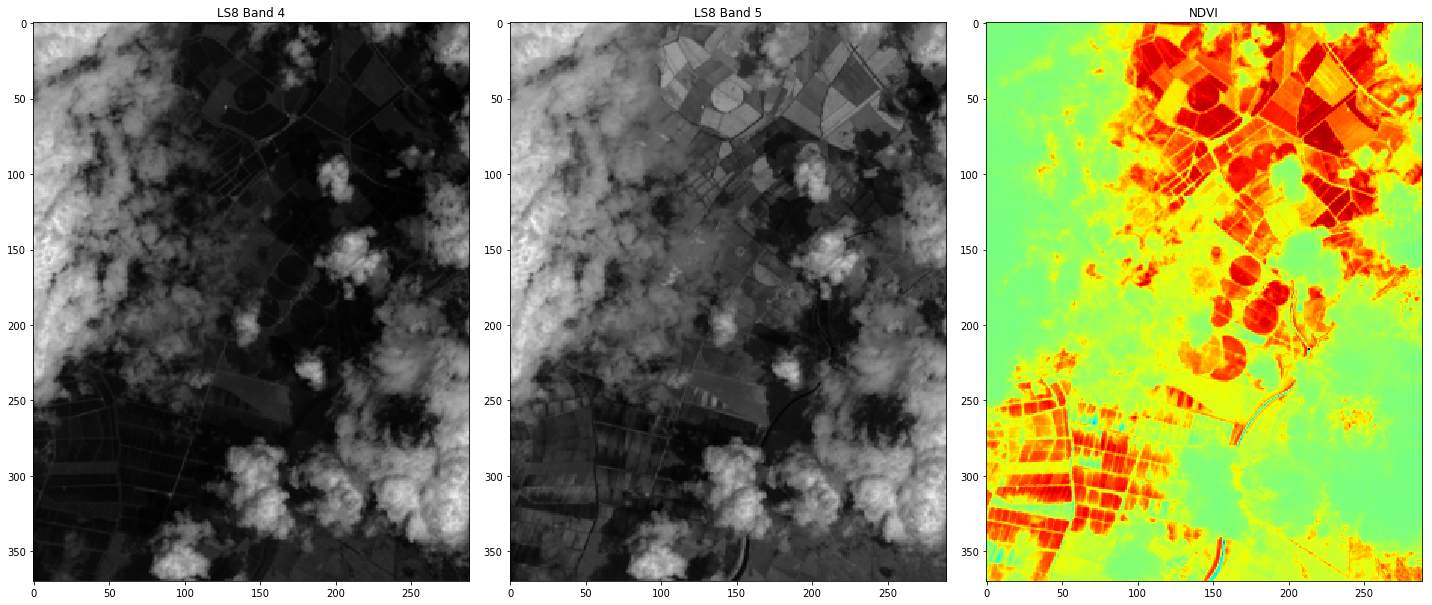

In [633]:
if check_results:
    
    ds = gdal.Open(band_1_name)
    band4 = ds.GetRasterBand(1).ReadAsArray()
    ds=None

    ds = gdal.Open(band_2_name)
    band3 = ds.GetRasterBand(1).ReadAsArray()
    ds=None

    ds = gdal.Open('{0}.TIF'.format(output_name))
    ndvi = ds.GetRasterBand(1).ReadAsArray()
    ds=None

    for b in [band3, band4, ndvi]:

        bmin = b[b!=-9999].min()
        bmax =  b[b!=-9999].max()
        
        if bmin != bmax:    
            b[b!=-9999] = (b[b!=-9999] - bmin)/(bmax - bmin) * 255
  
        b[b==-9999]=np.nan

    fig = plt.figure(figsize=(20,20))

    a = fig.add_subplot(1,3,1)
    imgplot = plt.imshow(band3.astype(np.uint8),cmap='gray')
    a.set_title('LS7 Band 3')
    if lscode == 'LC08':
        a.set_title('LS8 Band 4')
    

    a = fig.add_subplot(1,3,2)
    imgplot = plt.imshow(band4.astype(np.uint8),cmap='gray')
    a.set_title('LS7 Band 4')
    if lscode == 'LC08':
        a.set_title('LS8 Band 5')
        

    a = fig.add_subplot(1,3,3)
    imgplot = plt.imshow(ndvi.astype(np.uint8),cmap='jet')
    a.set_title('NDVI')

    plt.tight_layout()
    fig = plt.gcf()
    plt.show()

    fig.clf()
    plt.close()


### Remove temporay files and folders

In [635]:
ciop.log("INFO", "Removing aux data")

rm_cfolder(temp_folder)

os.rmdir(temp_folder)

global name 'shutil' is not defined


reporter:status:2019-09-05T18:41:09.548325 [INFO   ] [user process] Removing aux data
2019-09-05T18:41:09.548325 [INFO   ] [user process] Removing aux data


OSError: [Errno 39] Directory not empty: 'temp'

In [634]:
temp_folder

'temp'